In [1]:
# There are no publically available clavicle segmentation datasets that segment the entire clavicle

# This analysis uses a image and segmentation from a research paper figure to evaluate
# how well the chestx_det model is at segmenting clavicles.
# https://onlinelibrary.wiley.com/doi/10.1155/2020/2785464

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import torchxrayvision as xrv

/home/users/joecohen/workspace/torchxrayvision/torchxrayvision/utils.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
img = skimage.io.imread("clavicle-data/johe2785464-fig-0003a-m.png")

In [5]:
img.shape

(498, 500, 3)

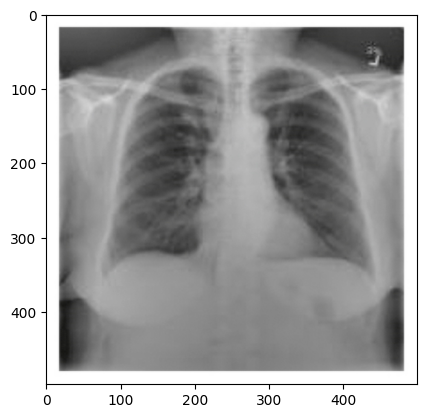

In [6]:
plt.imshow(img);

In [7]:
seg_gt = skimage.io.imread("clavicle-data/johe2785464-fig-0003b-m.png")

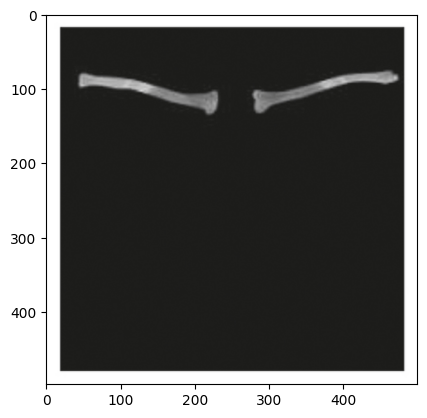

In [8]:
plt.imshow(seg_gt);

In [9]:
seg_gt.shape

(498, 500, 3)

In [10]:
seg_gt[:20, :] = 0
seg_gt[:, -20:] = 0
seg_gt[-20:, :] = 0
seg_gt[:, :20] = 0

In [11]:
seg_gt = (seg_gt[:,:,0] > 100)

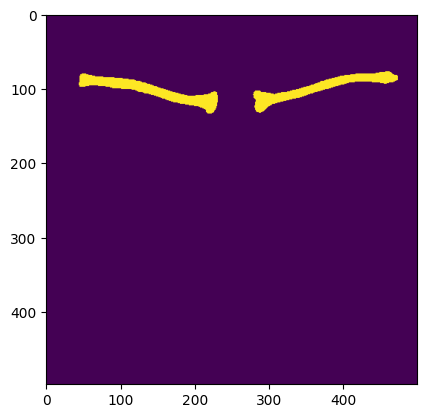

In [12]:
plt.imshow(seg_gt);

In [13]:
model = xrv.baseline_models.chestx_det.PSPNet()

In [14]:
model

chestx-det-pspnet

In [15]:
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img = img.mean(2)[None, ...] # Make single color channel

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop()])

img = transform(img)
img = torch.from_numpy(img)

In [16]:
seg_gt = transform(seg_gt[None,...])

In [17]:
img.shape

torch.Size([1, 498, 498])

In [18]:
with torch.no_grad():
    pred = model(img)

In [19]:
pred.shape

torch.Size([1, 14, 512, 512])

In [20]:
pred = torch.nn.functional.interpolate(pred, size=[498, 498])

In [21]:
pred.shape

torch.Size([1, 14, 498, 498])

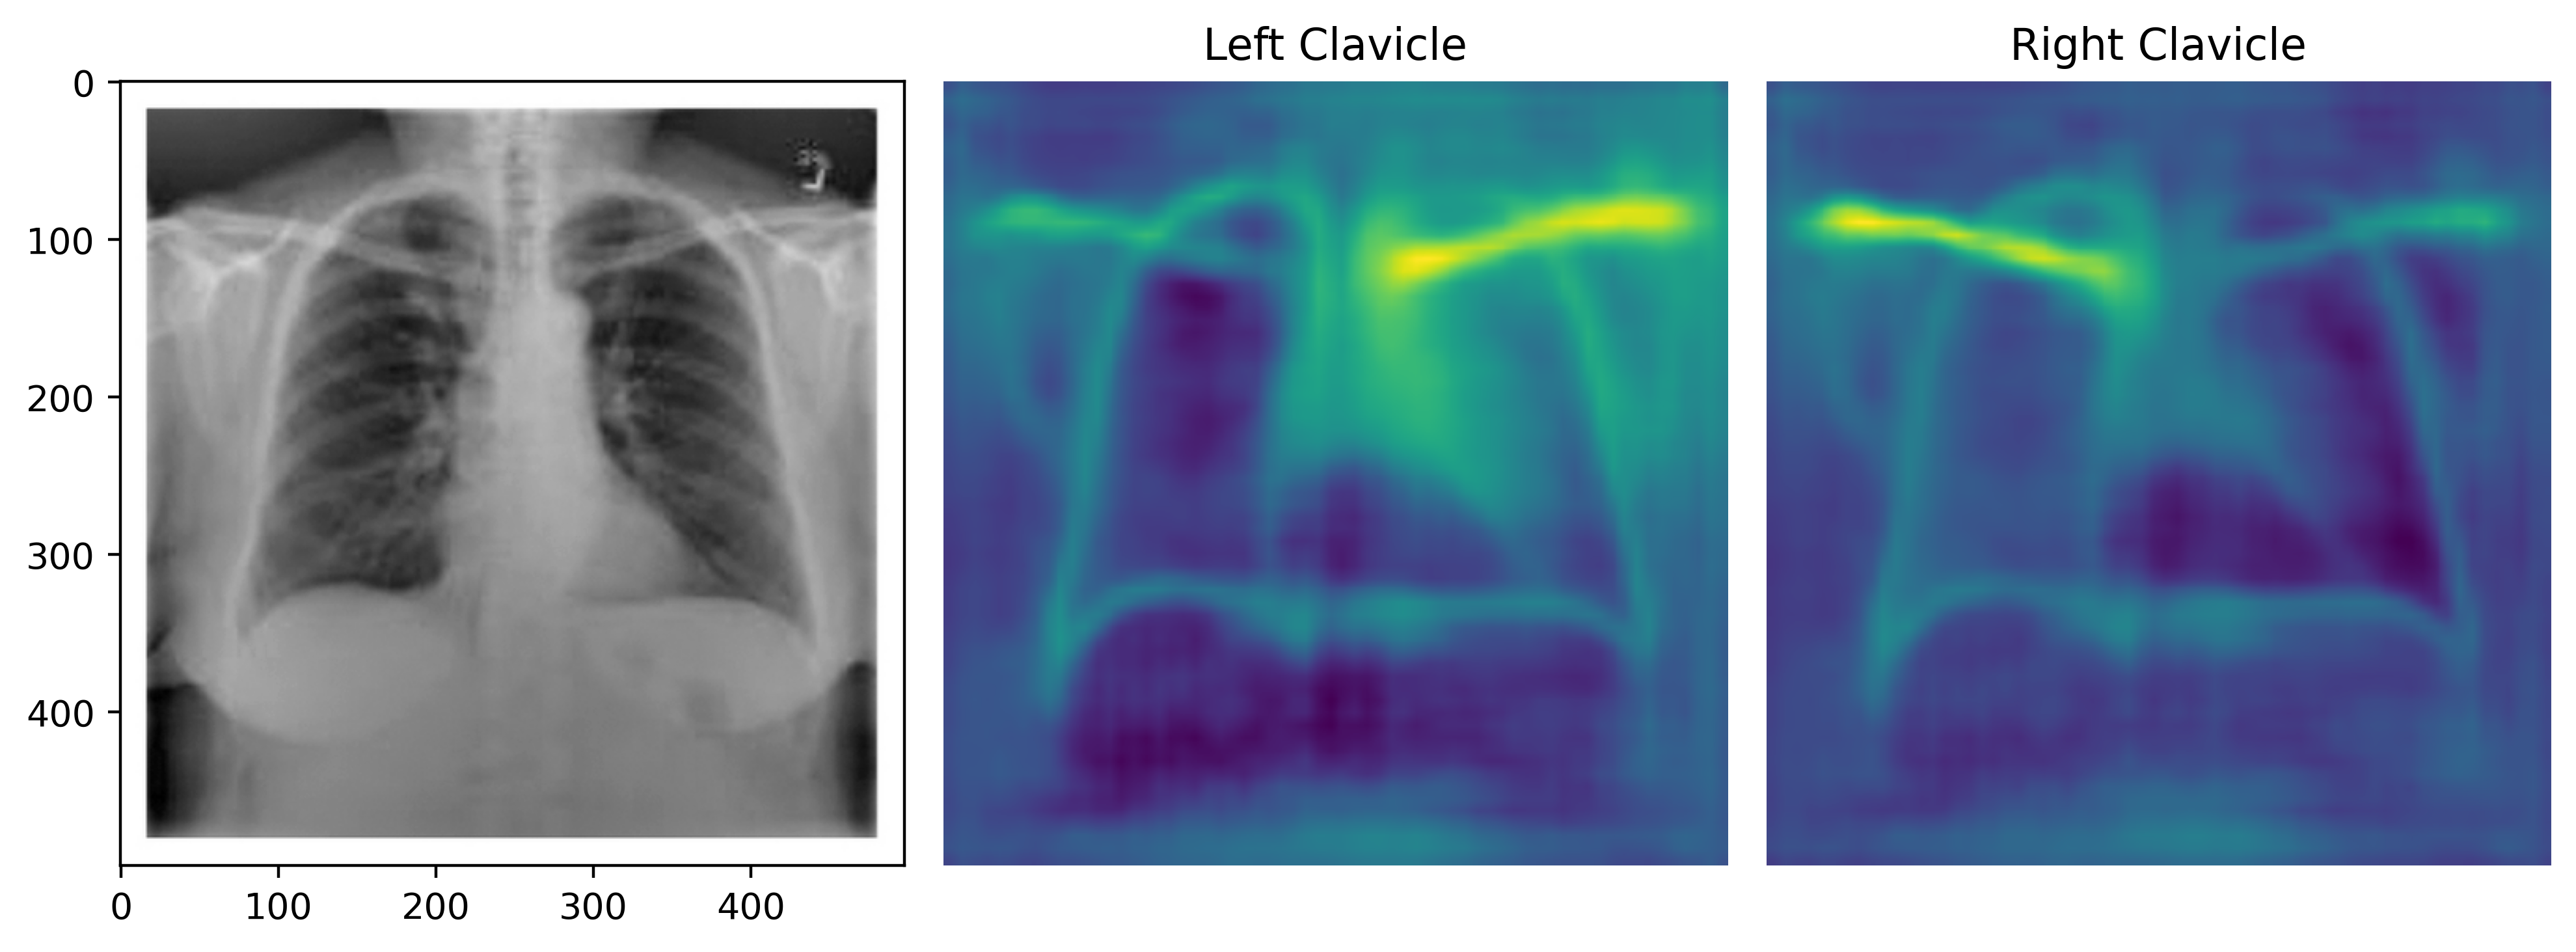

In [22]:
plt.figure(figsize = (10,5), dpi=400)
plt.subplot(1, 3, 1)
plt.imshow(img[0], cmap='gray')
for i in range(2):
    plt.subplot(1, 3, i+2)
    plt.imshow(pred[0, i])
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()

In [23]:
pred = 1 / (1 + np.exp(-pred))  # sigmoid
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1

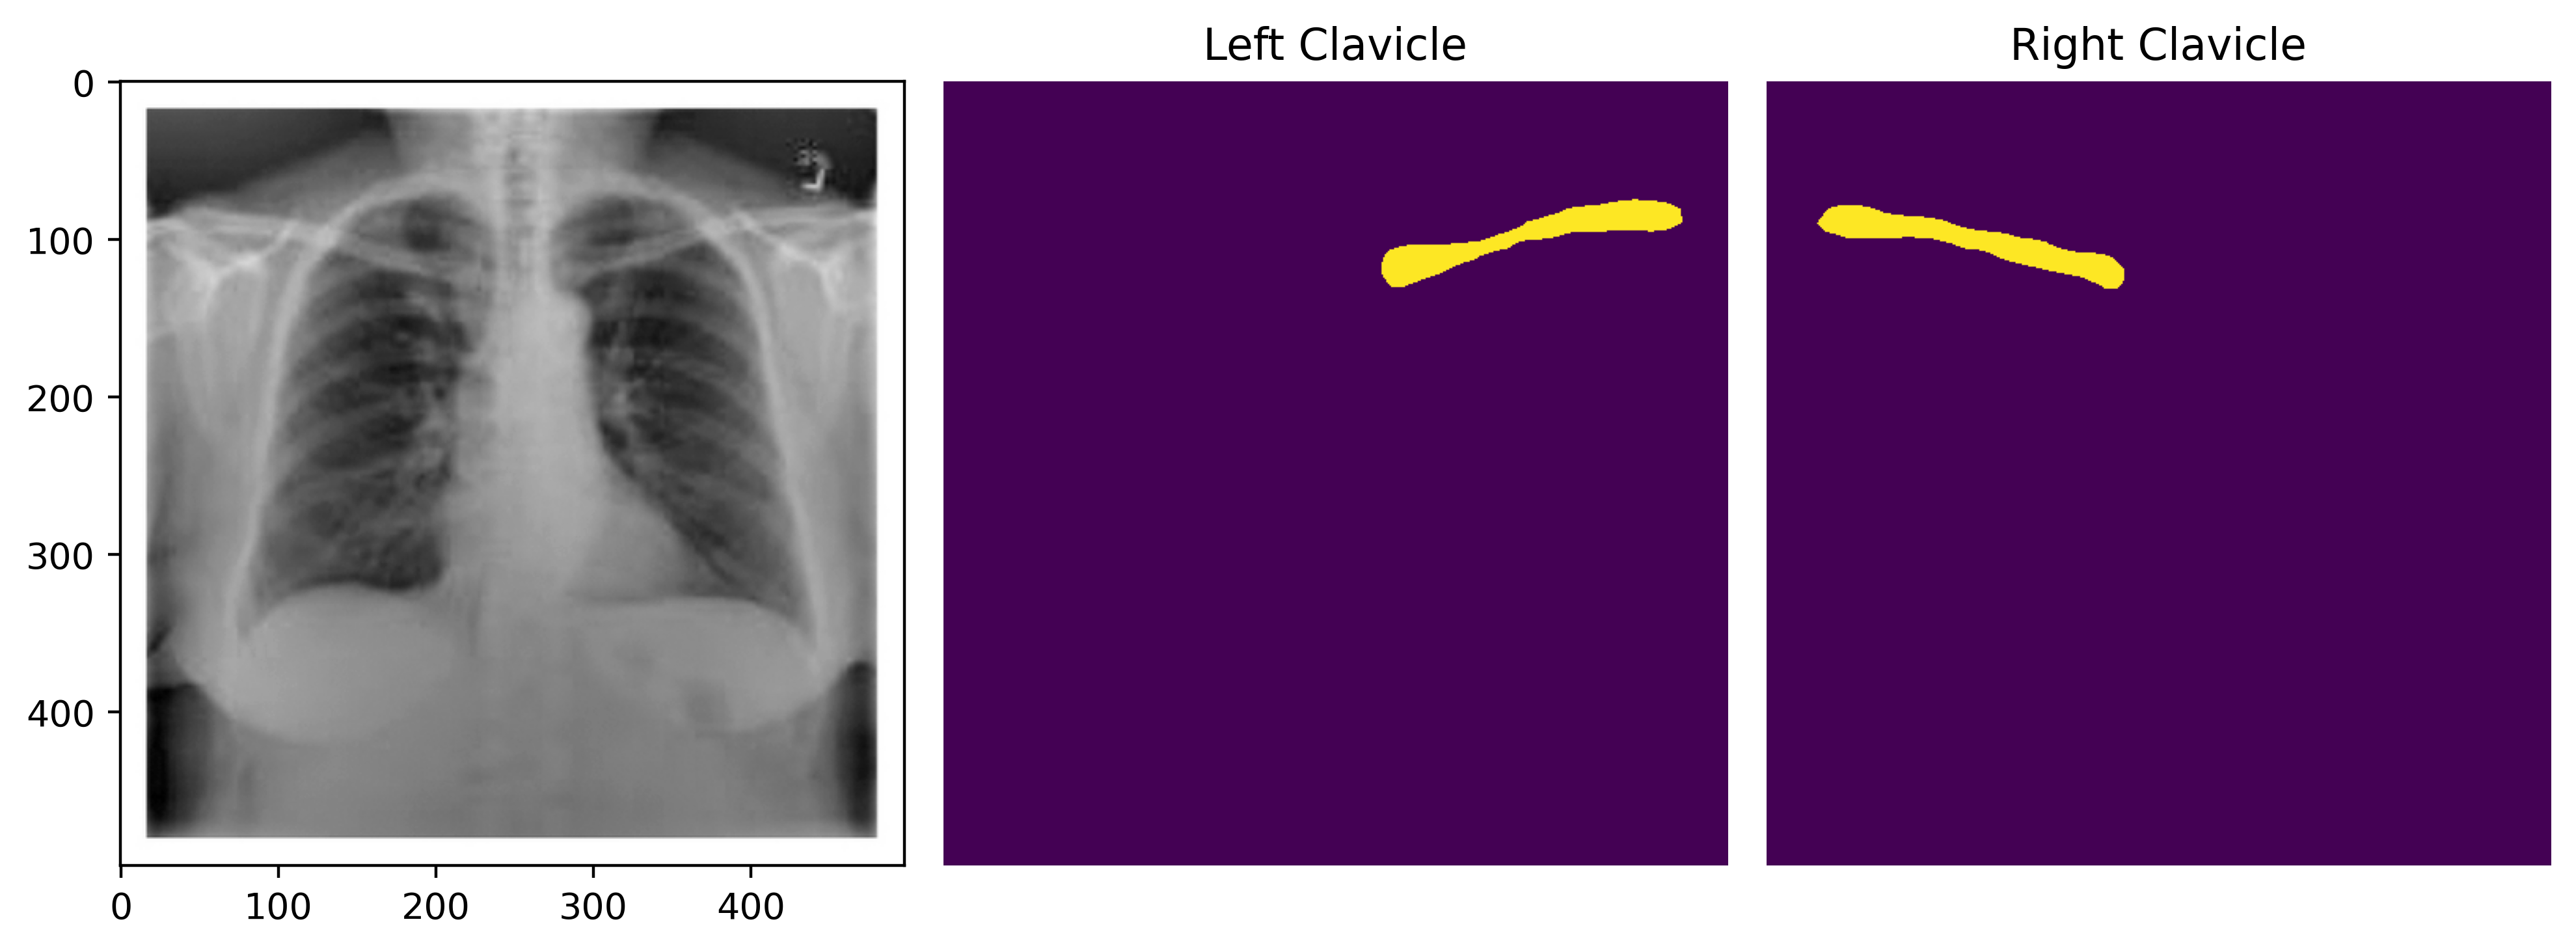

In [24]:
plt.figure(figsize = (10,5), dpi=400)
plt.subplot(1, 3, 1)
plt.imshow(img[0], cmap='gray')
for i in range(2):
    plt.subplot(1, 3, i+2)
    plt.imshow(pred[0, i])
    plt.title(model.targets[i])
    plt.axis('off')
plt.tight_layout()

In [25]:
pred_clavicles = torch.logical_or(pred[0,model.targets.index('Left Clavicle')],pred[0,model.targets.index('Right Clavicle')])

In [26]:
pred_clavicles.shape

torch.Size([498, 498])

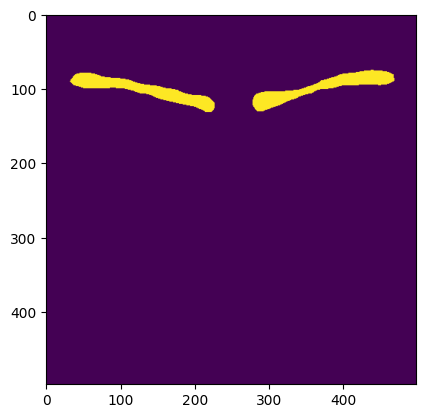

In [27]:
plt.imshow(pred_clavicles);

In [28]:
seg_gt.shape

(1, 498, 498)

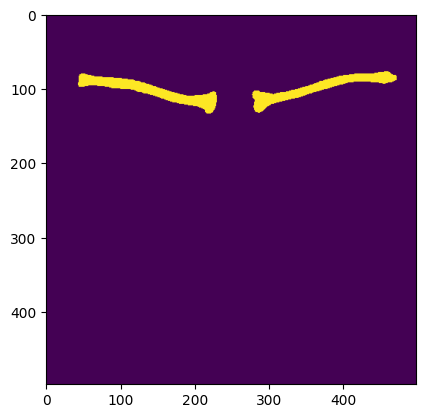

In [29]:
plt.imshow(seg_gt[0]);

In [30]:
torch.from_numpy(seg_gt[0]).flatten()

tensor([False, False, False,  ..., False, False, False])

In [31]:
pred_clavicles.flatten()

tensor([False, False, False,  ..., False, False, False])

In [32]:
def compute_iou(tensor1, tensor2, threshold=None):
    if threshold is not None:
        tensor1 = (tensor1 > threshold).float()
        tensor2 = (tensor2 > threshold).float()

    intersection = (tensor1 * tensor2).sum()
    union = ((tensor1 + tensor2) > 0).float().sum()

    if union == 0:
        return torch.tensor(1.0)  # Define IoU as 1 if both are completely empty
    else:
        return intersection / union
        

In [33]:
compute_iou(torch.from_numpy(seg_gt[0]).flatten(),pred_clavicles.flatten())

tensor(0.7533)